# PyTorch

PyTorch is a deep learning library built around tensors and tensor operations. A tensor is a multi-dimensional array of values with other parameters, such as gradients, associated with them. Neural networks are composed of tensors and operations which act on them. Loss functions are defined in terms of tensor operations as well. PyTorch provides other classes implementing optimizers and other facilities.

Tensors are easily created from Numpy arrays or simple Python lists of numbers:

In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt

n=np.array([[1.,2.],[3.,4.]])
print(n)

t=torch.tensor(n)
print(t)

[[1. 2.]
 [3. 4.]]
tensor([[1., 2.],
        [3., 4.]], dtype=torch.float64)


Tensors are evaluated immediately upon an expression being resolved, exactly like Numpy arrays:

In [2]:
x=torch.tensor([1.,2.])
y=torch.tensor([3.,4.])

print(x+y)

tensor([4., 6.])


Neural layers are composed of multiple tensors:

In [3]:
n=torch.nn.Linear(3,4)
print(n)

print(n.weight.shape,n.weight)
print(n.bias.shape,n.bias)

Linear(in_features=3, out_features=4, bias=True)
torch.Size([4, 3]) Parameter containing:
tensor([[-0.3664, -0.4194, -0.5759],
        [ 0.4584,  0.0533, -0.0932],
        [ 0.4911, -0.0381, -0.3643],
        [-0.4597, -0.5349,  0.3650]], requires_grad=True)
torch.Size([4]) Parameter containing:
tensor([-0.2731,  0.5097,  0.0411, -0.3513], requires_grad=True)


We have defined `n` as mapping values from $R^3$ space to $R^4$ and as we see the tensor defining its weight has the shape `[4,3]` as expected, and the bias has shape `[4]`. 

Notice that the `requires_grad` value is set to `True` for those tensors, this means their `grad` parameter for storing the gradients during training will be used, that is they represent trainable parameters in a network. Such tensors can be created manually:

In [4]:
trainable=torch.tensor([1.,2.],requires_grad=True)

print(trainable)
print(trainable.grad)

tensor([1., 2.], requires_grad=True)
None


The `grad` value is `None` currently since no gradient operation has been done. Using a loss function (in this case L1 or mean absolute error) we can get a tensor which has a gradient to back-propagate onto `trainable`:

In [5]:
loss=torch.nn.L1Loss() # create a loss function
l=loss(torch.tensor([2.,2.]),trainable) # the difference between `trainable` and this tensor is the "loss" here

l.backward() # back-propagate the loss

print(l.item()) # use .item() to get the the value out of a single-value tensor
print(trainable.grad)

0.5
tensor([-0.5000, -0.0000])


This gradient value is what an optimizer would use to update the actual values the network contains in an attempt to minimize the loss value `l`. Training a network is the process of generating a prediction, comparing the prediction against the expected output using a loss function, and then having the optimizer update the weights in your network to minimize that difference, then trying that process again. 

For example, using the `SGD` optimizer get our tensor `trainable` to differ minimally compared to our ground truth:

In [6]:
opt=torch.optim.SGD([trainable],lr=0.25) # lr is the learning rate, ie. how fast we want to change net parameters
iters=10
target=torch.tensor([2.,2.])

for i in range(iters):
    opt.zero_grad() # zero gradients
    l=loss(target,trainable) # compute loss
    l.backward() # back-propagate gradients
    opt.step() # apply gradients to values scaled by learning rate
    print(l.item())
    
print(trainable,'is the same as',target)

0.5
0.4375
0.375
0.3125
0.25
0.1875
0.125
0.0625
0.0
0.0
tensor([2., 2.], requires_grad=True) is the same as tensor([2., 2.])


This is a very simplified example that could have been done in a much simpler way but it illustrates the steps involved. 

### Defining Your Own Modules
Modules are the components of networks, containing weights and the code to perform forward and backward passes. We will see the definition of our networks as modules so it's important to understand what PyTorch expects. 

In general the module definition we will use follows this outline:

In [7]:
class ModuleName(torch.nn.Module):
    def __init__(self): # constructor
        super().__init__() # required before defining components
        self.net=torch.nn.Linear(4,10)
        
    def forward(self,x): # defines forward pass of network
        x=self.net(x) # do forward pass of components and pass along result
        return x

PyTorch requires that we define the forward pass of modules, this is done in the `forward()` method which is inherited form `Module`. You can define the backward pass to calculate a derivative for your network however you like but that is beyond the scope here. 

## Learning Example with Iris Dataset
The Iris dataset is a list of four measurements of iris flowers drawn from three species. There are 150 instances in total which we will use to train a network to predict the species based on the measurements.

More information on the dataset can be found here: https://archive.ics.uci.edu/ml/datasets/Iris

First thing to do is download the data if you're in a Colab notebook:

In [8]:
![ -f iris.csv ] || wget https://github.com/ericspod/VPHSummerSchool2019/raw/master/iris.csv
![ -f seeds.csv ] || wget https://github.com/ericspod/VPHSummerSchool2019/raw/master/seeds.csv
![ -f boston_test.csv ] || wget https://github.com/ericspod/VPHSummerSchool2019/raw/master/boston_test.csv
![ -f boston_train.csv ] || wget https://github.com/ericspod/VPHSummerSchool2019/raw/master/boston_train.csv

Next thing is to read the dataset into a numpy array:

In [9]:
import io

# read the data from a file 
with open('iris.csv') as o: # `with` block opens file and produces file object `o` then closes it on exit
    header=o.readline() # read the first line of the file but don't use it for anything
    dat=o.read()

# replace category names with numbers
dat=dat.replace('Iris-setosa','0') 
dat=dat.replace('Iris-versicolor','1') 
dat=dat.replace('Iris-virginica','2') 

dat=np.genfromtxt(io.StringIO(dat),delimiter=',',dtype=np.float32) # convert csv to array
print(dat.shape,dat.dtype)

(150, 5) float32


The array `dat` now contains an array of flower measurements, where the columns are:
* Sepal length (cm)
* Sepal width (cm) 
* Petal length (cm)
* Petal width (cm) 
* Species class: Iris Setosa=0, Iris Versicolour=1, Iris Virginica=2

The table contains 50 examples of each species in contiguous sections, ie. the first 50 are Iris Setosa. To divide the data into training and test sets we want to take some of each species out to use as test data to verify our model works. If we split each category into 45 for train and 5 for test, we can define the indices for each category to create `train` and `test` tensors:

In [10]:
numOfEachClass=50 # number of entries per category
trainSize=45 # number of entries from each category to keep as training set
arrayRange=np.arange(150) # indices over the whole data set

# index of each entry within a class (ie. index of first entry of next category starts at 0)
perClassIndices=arrayRange%numOfEachClass 

train=dat[perClassIndices<trainSize]
test=dat[perClassIndices>=trainSize]
print(train.shape,test.shape)

(135, 5) (15, 5)


We can now convert these arrays into PyTorch tensor types:

In [11]:
trainT=torch.tensor(train)
testT=torch.tensor(test)
print(trainT.shape, trainT.dtype)

torch.Size([135, 5]) torch.float32


The `trainT` and `testT` tensors have 5 rows, the first 4 are the measurements and the last is the class. When training we want to give the network the measurements and input then compare the results against the known classes. In `trainT` we can reference the measurements only as `trainT[:,:4]` meaning "everying up to but not including the 4th column", and the classes `trainT[:,4]`.

We define our simple network which goes from 4 input neurons to 10 hidden ones, then from these 10 to 3 output neurons giving the probability the input was a member of each of the 3 classes:

In [12]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.ln1=torch.nn.Linear(4,10)
        self.ln2=torch.nn.Linear(10,3)
        self.act=torch.nn.Softmax(dim=1)
        
    def forward(self,x):
        x=self.ln1(x)
        x=self.ln2(x)
        x=self.act(x)
        return x

Finally we can train our network for a number of steps:

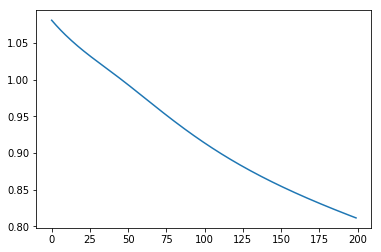

In [13]:
net=Net() # create our instance of the network

loss=torch.nn.CrossEntropyLoss() # entropy loss between probability dimensions and categories
opt=torch.optim.Adam(net.parameters(),lr=0.001) # an adaptive optimizer that almost always is best

iters=200
losses=[]

for i in range(iters):
    opt.zero_grad() # clear out the gradients from the optimizer
    cat=net(trainT[:,:4]) # do a forward pass on the network
    lossval=loss(cat,trainT[:,4].long()) # calculate loss between prediction and ground truth
    # loss function wants values as integers so use .long() to convert
    
    lossval.backward() # do a backward pass on the network to update weights
    opt.step() # apply the updates
    
    losses.append(lossval.item()) # save the loss value, .item() gets a single value out of a tensor
        
plt.plot(losses)

In [14]:
testcat=net(testT[:,:4])
numCorrect=torch.sum(testcat.max(1)[1]==testT[:,4].long()).item()
print('Number of correct predictions:',numCorrect,'out of',testT.size(0))

Number of correct predictions: 12 out of 15


#### Exercises:
1. The parameter `iters` above sets the number of iterations, try changing this to larger or smaller values and see how the results vary.
2. The parameter `lr` is the learning rate the optimizer, essentially how fast it tries to move the weights of the network in the right direction. Try larger or smaller values for this as well
3. Our network is really simple, containing only 2 layers and an activation. More layers may help get a better result, and using activation between layers (ie. ReLU) may be helpful as well. Try adding activation or more layers, if these help you may want to reduce the number of training iterations to see the difference.
4. We've chosen a train:test ratio of 45:5, try having a larger test set and see how this affects performance. 
5. We haven't randomly shuffled the dataset either, you can experiment with that (search for `numpy.random`) and just choose the last `N` entries and your test set.
6. We've also included a `seeds.csv` dataset of seed measurements plus a species category with 3 classes (Kama, Rosa, Canadian). Adapt your code above to use this dataset instead and see how your results vary. Would a different network help? Note that there are a differing number of instances per class which you will have to account for when dividing the training and testing set.

#### Advanced Exercise

The files `boston_train.csv` and `boston_test.csv` contain data for the Boston House Prices Dataset (info here: https://www.kaggle.com/c/boston-housing/overview). This is composed of 13 statistics for various towns followed by the median house price. 

We want to train a network which predicts the price based on the 13 stats. This is a regression problem where we are attempting to define a continuous function rather than attempting to categorize as the above examples are. What you've seen above and modified during the exercises can be applied to this task as well, what will be different is the activation function your network will use since this isn't a statistical problem, and the loss function since we're not doing a statistical comparison versus a ground truth category assignment. 